# Analyze the sequence similarity of the barcodes.
# And calculate the frequency of overlapping barcodes in different groups with the input.
### The notebook takes ~10min to run

In [3]:
from distance import hamming
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from glob import glob

In [5]:
infiles = sorted(glob('sorted/*'))

In [47]:
adata = {}
for infile in infiles:
    sample = infile.rsplit('/')[-1].rsplit('.csv')[0]
    adata[sample] = pd.read_csv(infile,names=['seq','count','freq'],header=1,index_col=0)

In [48]:
samplelist = list(adata.keys())

In [49]:
adata = pd.concat(adata)
adata

seq  count          freq
BC4_P0    1       AAAAAAAAATCATAAGATAA    1.0  1.111719e-08
          2       AAAAAAAAATTAAGAAGCAG    1.0  1.111719e-08
          3       AAAAAAAAATTATAAGAAAG    1.0  1.111719e-08
          4       AAAAAAAAATTTTAAGGAAA    1.0  1.111719e-08
          5       AAAAAAAAGCATAGAAATAG    1.0  1.111719e-08
...                                ...    ...           ...
G3_3_lung 947278  TTTTTGGTGTTTTGGGATAG    1.0  5.268456e-08
          947279  TTTTTGGTTTATTAGGGAAG    1.0  5.268456e-08
          947280  TTTTTGGTTTTATAGGATGG    1.0  5.268456e-08
          947281  TTTTTTATTCTTATATATAA    1.0  5.268456e-08
          947282  TTTTTTTATCTTAAAGATGA    1.0  5.268456e-08

[7632804 rows x 3 columns]

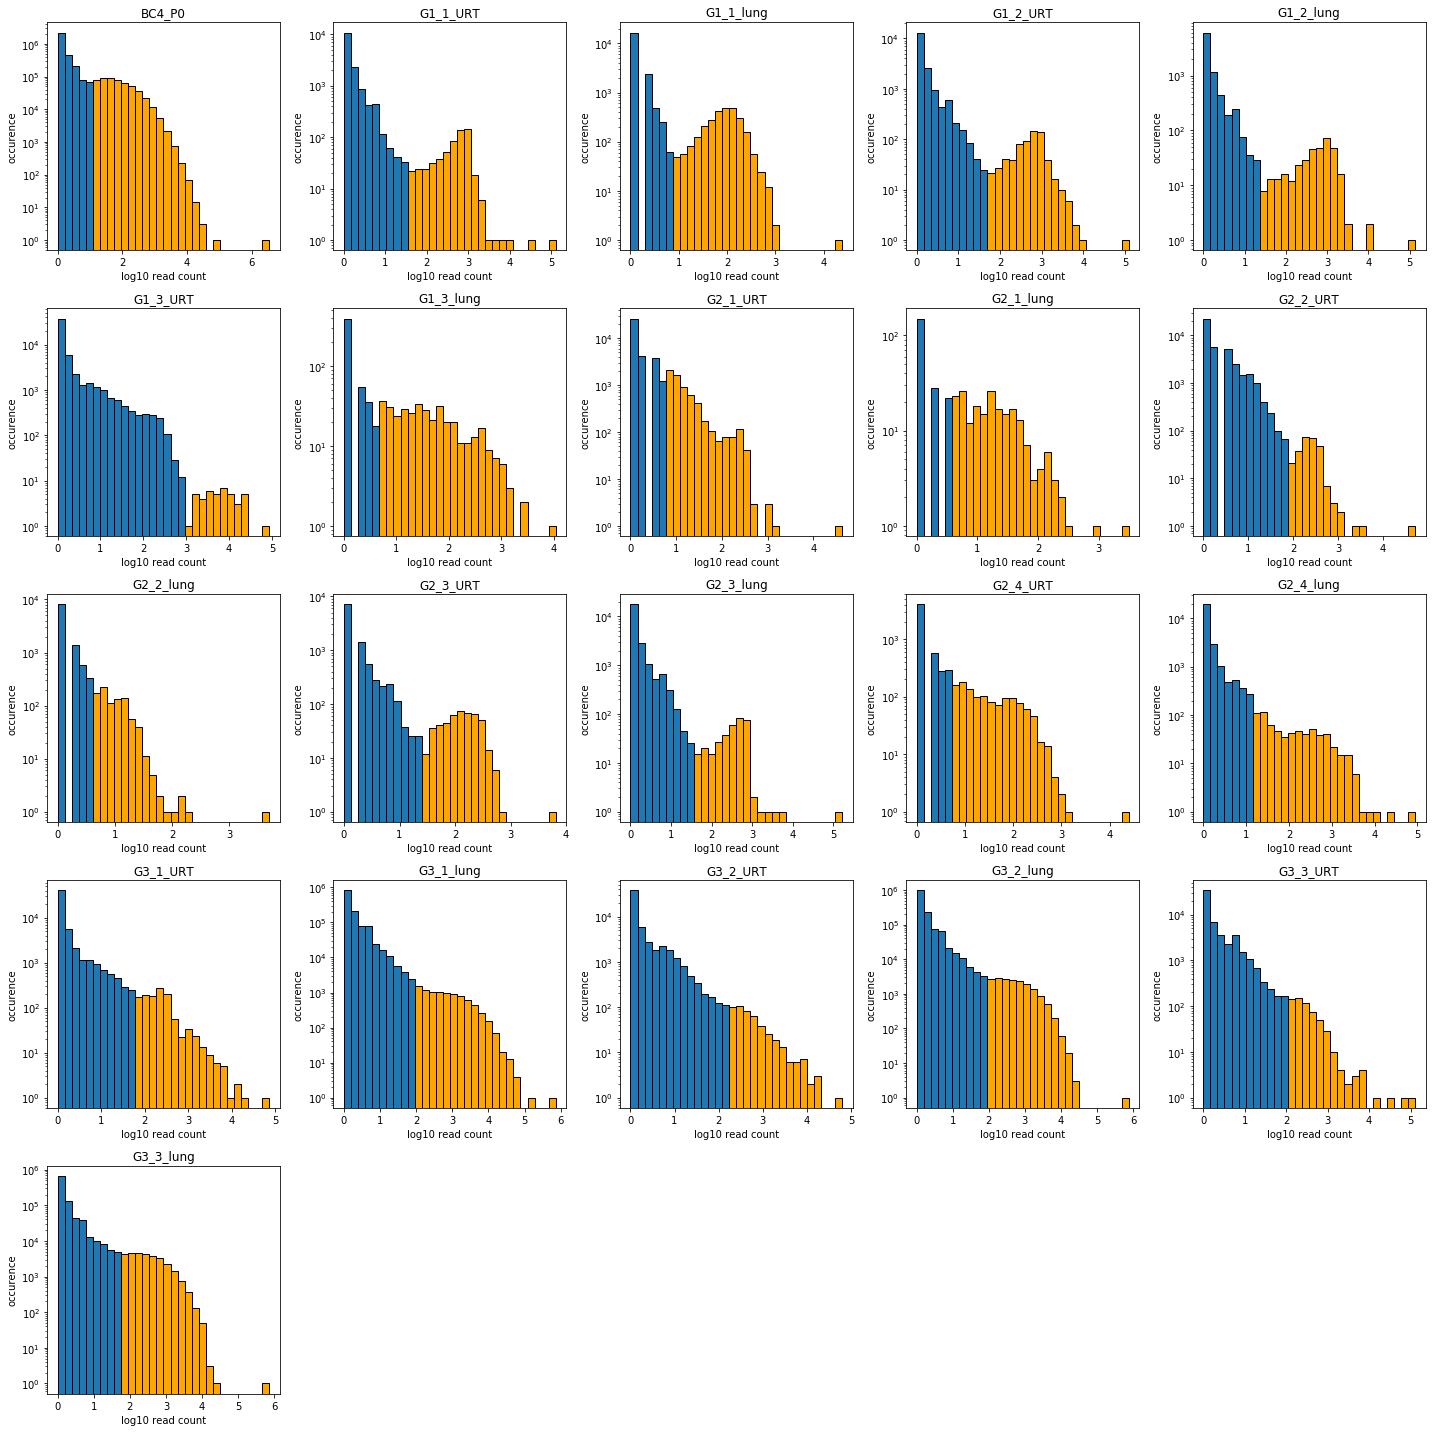

In [110]:
thredict = {}
plt.figure(figsize=(20,20))
ploti = 0
for sample in samplelist:
    ploti += 1
    plt.subplot(5,5,ploti)
    ns,bins,patches = plt.hist(np.log10(adata.loc[sample]['count']),bins=30,edgecolor='black')
    plt.yscale('log')
    plt.xlabel('log10 read count')
    plt.ylabel('occurence')
    plt.title(sample)
    st = 5
    if sample == 'G1_3_URT': st = 15
    if sample == 'G2_3_URT': st = 8
    if sample == 'G2_2_URT': st = 8
    for i in range(len(ns))[st:]:
        if ns[i] > ns[i-1]:
            thredict[sample] = bins[i-1]
            break
    if sample == 'G3_1_lung': thredict[sample] = bins[10]
    for i in range(len(ns))[st:]:
        if bins[i] >= thredict[sample]:
            patches[i].set_facecolor('orange')
plt.tight_layout()

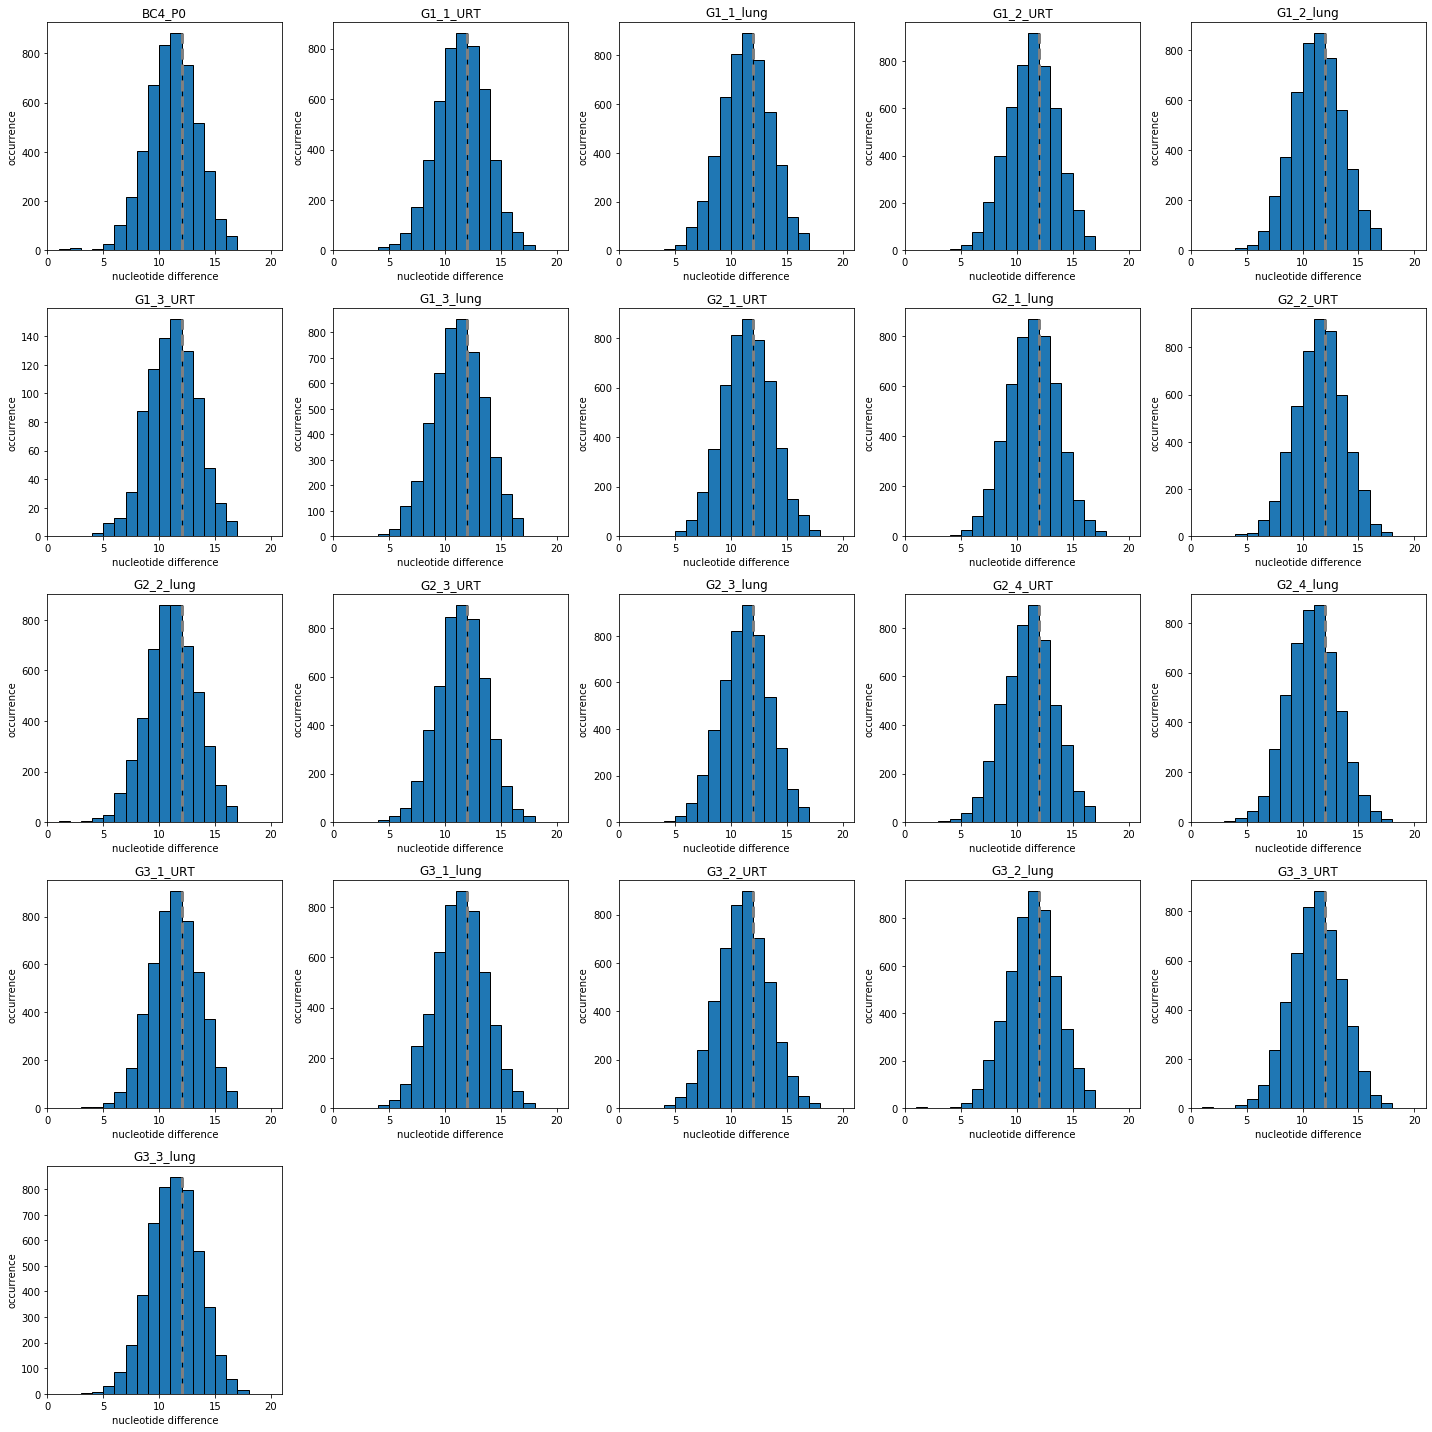

In [126]:
plt.figure(figsize=(20,20))
for ploti, sample in enumerate(samplelist):
    plt.subplot(5,5,ploti+1)
    bclist = adata[adata['count']>10**thredict[sample]].loc[sample]
    bclist = list(bclist.sort_values('count',ascending=False)['seq'])[:100]
    distlist = []
    for i in range(len(bclist)):
        for j in range(i+1,len(bclist)):
            distlist.append(hamming(bclist[i],bclist[j]))  
    n,bins,pathes = plt.hist(distlist,bins=range(min(distlist),max(distlist)),edgecolor='black')
    plt.xlabel('nucleotide difference')
    plt.ylabel('occurrence')
    plt.title(sample)
    plt.xlim([0,21])
    plt.vlines(12,0,max(n),colors='grey',linestyle='--',lw=3)
plt.tight_layout()

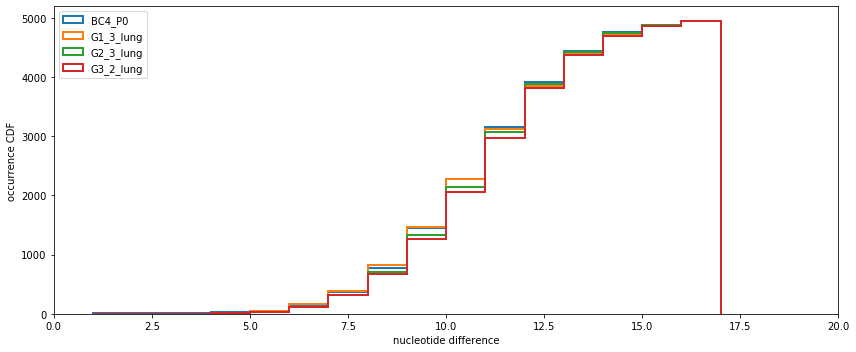

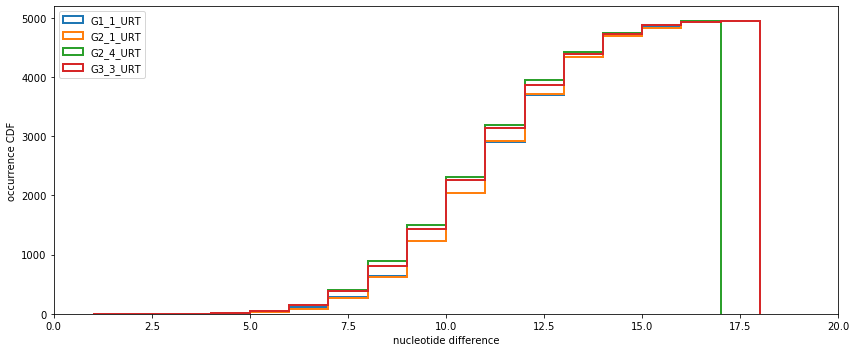

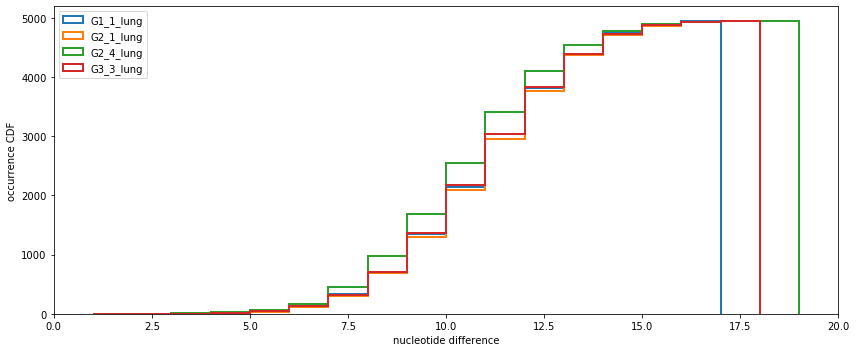

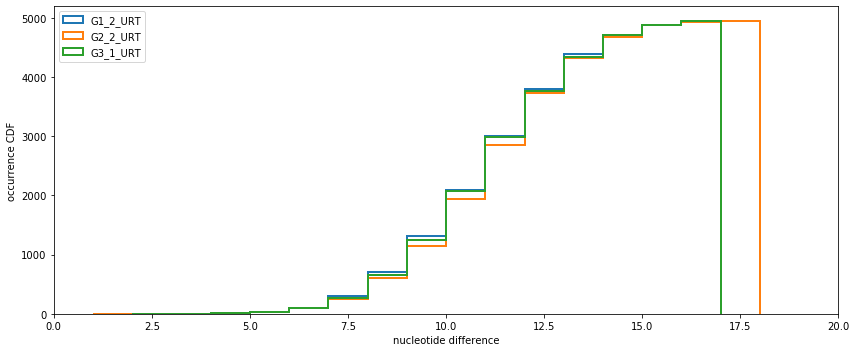

In [127]:
for group in range(4):
    plt.figure(figsize=(12,5))
    for ploti, sample in enumerate(samplelist[group::6]):
        bclist = adata[adata['count']>10**thredict[sample]].loc[sample]
        bclist = list(bclist.sort_values('count',ascending=False)['seq'])[:100]
        distlist = []
        for i in range(len(bclist)):
            for j in range(i+1,len(bclist)):
                distlist.append(hamming(bclist[i],bclist[j]))  
        plt.hist(distlist,bins=range(min(distlist),max(distlist)),histtype='step',cumulative=True,label=sample,lw=2)
    plt.xlabel('nucleotide difference')
    plt.ylabel('occurrence CDF')
    plt.xlim([0,20])
    plt.legend(loc=2)
    plt.tight_layout()  

# No particular left shift in G1 and G2!!!
# This indicates no prevalent or dominant de novo mutation!!

In [111]:
ovmatrix = np.zeros((len(samplelist),len(samplelist)))
for i,s1 in enumerate(samplelist):
    for j,s2 in enumerate(samplelist):
        df1 = adata[adata['count']>10**thredict[s1]].loc[s1]
        df2 = adata[adata['count']>10**thredict[s2]].loc[s2]
        freq = sum(df1[df1['seq'].isin(df2['seq'])]['freq'])
        ovmatrix[i][j] = freq
            

In [118]:
#A little normalization to adjust frequency
freqm = np.zeros((len(samplelist),len(samplelist)))
for i in range(len(samplelist)):
    for j in range(len(samplelist)):
        freqm[i][j] = ovmatrix[i][j]/ovmatrix[i][i]

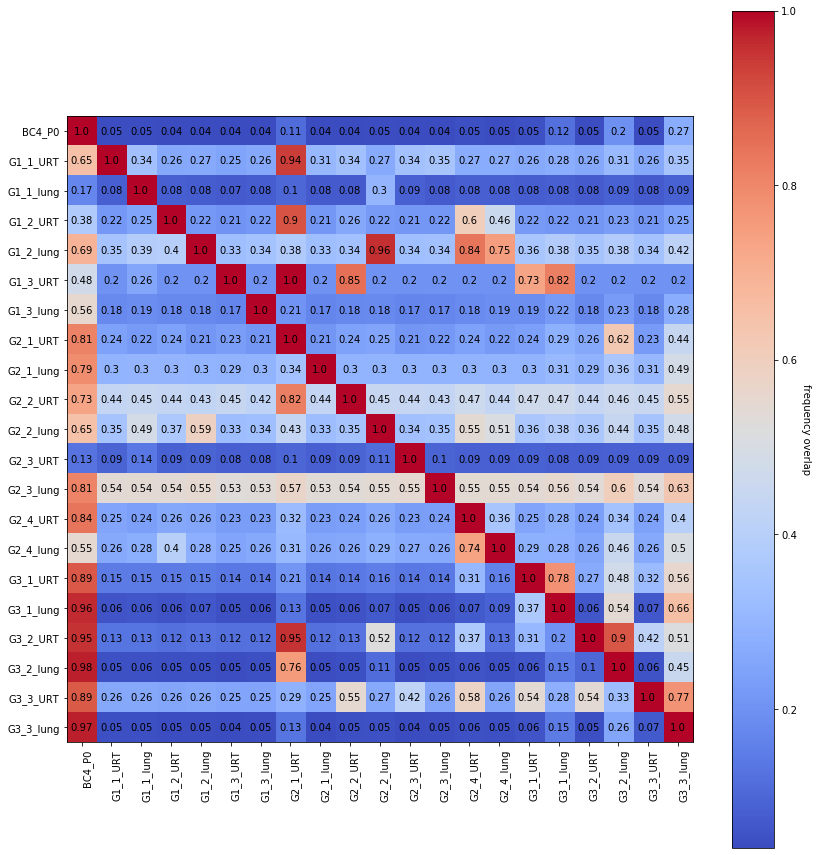

In [119]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(freqm,cmap='coolwarm')
ax.set_xticks(np.arange(len(samplelist)))
ax.set_yticks(np.arange(len(samplelist)))
ax.set_xticklabels(samplelist)
ax.set_yticklabels(samplelist)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
for i in range(len(samplelist)):
    for j in range(len(samplelist)):
        text = ax.text(j, i, round(freqm[i, j],2),
                       ha="center", va="center", color="black")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('frequency overlap', rotation=-90, va="bottom")
plt.tight_layout()

In [120]:
s1 = 'G2_3_URT'
df1 = adata[adata['count']>10**thredict[s1]].loc[s1]
df1.sort_values('count',ascending=False)

,seq,count,freq
6721,TACCTGGTGCATTACAATAA,6542.0,0.068109
4901,CGCTCAGATTATAGAGAAGG,752.0,0.007829
10104,TGTTCGGAGTTTAGCGGAGA,538.0,0.005601
1955,AGATAGGTGCAATGAGGTAG,531.0,0.005528
4476,CGATCAGTGTATTAAGGCGA,512.0,0.005330
...,...,...,...
2320,AGCTAAAAATTTAACAAAGA,30.0,0.000312
2637,AGTCGAATATAAAACGAAAA,29.0,0.000302
2318,AGCTAAAAACTATACAGTGA,28.0,0.000292
1175,AATCTAGTGTTATAGAAAGA,28.0,0.000292


In [121]:
s1 = 'G2_3_lung'
df1 = adata[adata['count']>10**thredict[s1]].loc[s1]
df1.sort_values('count',ascending=False)

,seq,count,freq
14518,TACCTGGTGCATTACAATAA,165950.0,0.470924
20807,TGCTAGATTCTATAGAGCGA,4884.0,0.013860
18587,TGACGAATATTTTGGAATGA,3551.0,0.010077
2126,AATCGAATACTAAAGGGTGA,2381.0,0.006757
21282,TGCTTAGTACTAAGCAATAG,1960.0,0.005562
...,...,...,...
14338,TACCTGGTATTTTGGGGAGA,41.0,0.000116
12196,TAACTGGTGCATTACAATAA,39.0,0.000111
14592,TACCTGGTGCATTATAATAA,39.0,0.000111
14397,TACCTGGTGCACTACAATAA,38.0,0.000108


# Not sure why G3 has more overlap with P0
# Let me remove TACCTGGTGCATTACAATAA and analyze again

In [122]:
sdata = adata[adata['seq']!='TACCTGGTGCATTACAATAA']

In [123]:
ovmatrix = np.zeros((len(samplelist),len(samplelist)))
for i,s1 in enumerate(samplelist):
    for j,s2 in enumerate(samplelist):
        df1 = sdata[sdata['count']>10**thredict[s1]].loc[s1]
        df2 = sdata[sdata['count']>10**thredict[s2]].loc[s2]
        freq = sum(df1[df1['seq'].isin(df2['seq'])]['freq'])
        ovmatrix[i][j] = freq

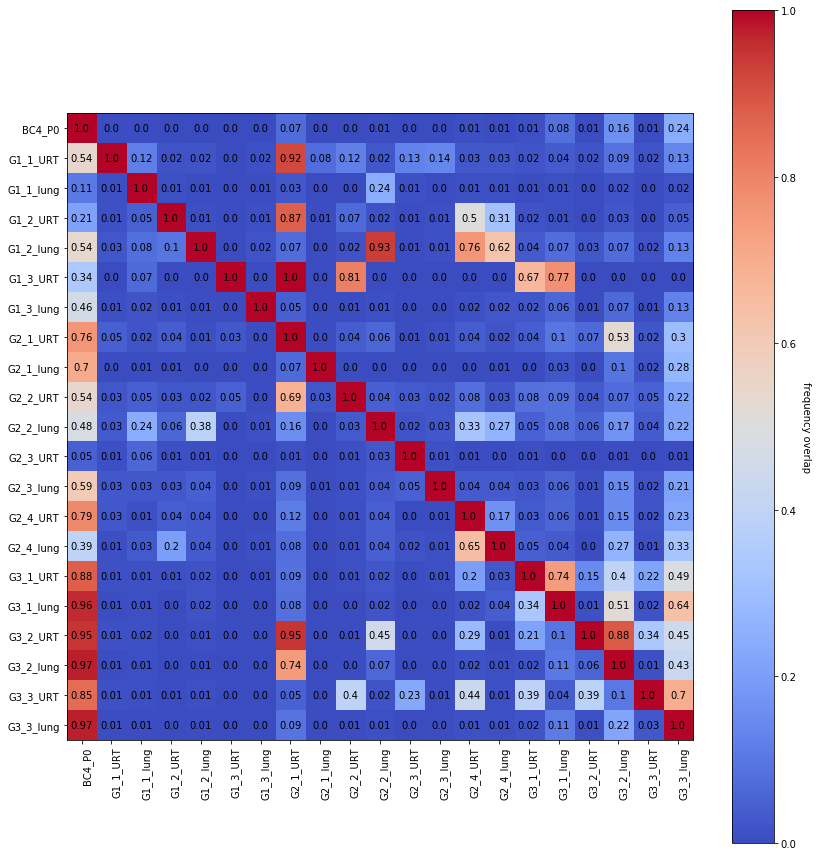

In [124]:
freqm = np.zeros((len(samplelist),len(samplelist)))
for i in range(len(samplelist)):
    for j in range(len(samplelist)):
        freqm[i][j] = ovmatrix[i][j]/ovmatrix[i][i]
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(freqm,cmap='coolwarm')
ax.set_xticks(np.arange(len(samplelist)))
ax.set_yticks(np.arange(len(samplelist)))
ax.set_xticklabels(samplelist)
ax.set_yticklabels(samplelist)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
for i in range(len(samplelist)):
    for j in range(len(samplelist)):
        text = ax.text(j, i, round(freqm[i, j],2),
                       ha="center", va="center", color="black")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('frequency overlap', rotation=-90, va="bottom")
plt.tight_layout()

# I tend to explain the low fidelity in G1 and G2 as sequencing errors. But I cannot explain why there is no CDF left-shift in G1/G2.
# Sequence did not tell much. Due to the computational power limit. I only focus on top 100 in calculating distance. But top 100 should exhibit the trend.
# Maybe we can remove some animals and do some stats.

By the way I want to warn about cross-contaminations.